In [34]:
import pandas as pd
# from piidetect.fakepii import Fake_PII, write_to_disk_train, write_to_disk_test
import os
print("Path at terminal when executing this file")
print(os.getcwd() + "\n")
#Make note of CWD- change it if you want- this is where your CSVs will end up

Path at terminal when executing this file
C:\Users\maddo\Downloads



In [35]:
from gensim.models import Word2Vec

In [36]:
fake_ = Fake_PII()
fake_.create_fake_profile(100)
train_labels, train_text, train_PII = fake_.create_pii_text_train(n_text = 5)
write_to_disk_train(300)
write_to_disk_test(300)

NameError: name 'Fake_PII' is not defined

In [37]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [38]:
df_temp = pd.read_csv("train.csv") # avoid header=None. 
shuffled_df = df_temp.sample(frac=1)
shuffled_df.to_csv("train_shuffled.csv", index=False)
df_temp_test = pd.read_csv("test.csv") # avoid header=None. 
shuffled_df_test = df_temp_test.sample(frac=1)
shuffled_df_test.to_csv("test_shuffled.csv", index=False)
train_data = pd.read_csv("train_shuffled.csv")
test_data = pd.read_csv("test_shuffled.csv")

In [39]:
import re
train_data['Labels'].value_counts()
def clean_text(text):
    # replace  . and a space with only a space, then amke all words lower case.
    text = text.replace(". "," ").replace(",","").lower()
    # get rid of the . at the end of each line.
    cleaned_text = re.sub("\.$","",text)

    return cleaned_text
def extract_special_len(text):
    # the complete special char list
    all_special_char = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    # return the special char if it is in the text
    special_list = [special_char for special_char in all_special_char\
                   if special_char in text]

    return len(special_list)


def extract_special_char(text):
    # the complete special char list
    all_special_char = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    # return the special char if it is in the text
    special_list = [special_char for special_char in all_special_char\
                   if special_char in text]

    return special_list
train_data["Cleaned_text"] = train_data["Text"].apply(clean_text)
train_data['Special_char_num'] = train_data["Cleaned_text"].apply(extract_special_len)
train_data['Special_chars'] = train_data["Cleaned_text"].apply(extract_special_char)
train_data.groupby("Labels").agg({'Special_char_num':["min","max","mean",'median']})
test_data["Cleaned_text"] = test_data["Text"].apply(clean_text)
test_data['Special_char_num'] = test_data["Cleaned_text"].apply(extract_special_len)
test_data['Special_chars'] = test_data["Cleaned_text"].apply(extract_special_char)
test_data.groupby("Labels").agg({'Special_char_num':["min","max","mean",'median']})

Special_char_num                     
                              min max      mean median
Labels                                                
Address                         0   0  0.000000      0
CreditCardNumber                0   0  0.000000      0
Email                           2   2  2.000000      2
Name                            0   0  0.000000      0
None                            0   0  0.000000      0
Phone_number                    0   3  1.463333      1
Plates                          0   1  0.263333      0
SSN                             0   1  0.560000      1

In [40]:
# train_data.to_csv("train_cleaned.csv",index=False)
# test_data.to_csv("test_cleaned.csv",index=False)

#You can look at these in your CWD to check that everything worked and use the generated data later

In [41]:
fake_pii = train_data[["Text", "Labels", "PII", "Cleaned_text"]]
fake_pii_test = test_data[["Text", "Labels", "PII", "Cleaned_text"]]
fake_pii['Target']= "1"
fake_pii_test['Target']= "1"
def binary_pii(label):
    pii_label = 0
    if label != "None":
        pii_label = 1
    return pii_label 
fake_pii["Target"] = fake_pii['Labels'].apply(binary_pii)
fake_pii_test["Target"] = fake_pii_test['Labels'].apply(binary_pii)
df = pd.DataFrame(data=fake_pii)
df_test = pd.DataFrame(data=fake_pii_test)
dfsample = df.sample(n=10,replace=True)
dfsample
df_testsample = df_test.sample(n=10,replace=True)

<ipython-input-41-895788e9eb24>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_pii['Target']= "1"
<ipython-input-41-895788e9eb24>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_pii_test['Target']= "1"
<ipython-input-41-895788e9eb24>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [42]:
context_sentences = [sentence.split(" ") for sentence in fake_pii.Cleaned_text]
context_sentences_test = [sentence.split(" ") for sentence in fake_pii_test.Cleaned_text]

In [43]:
word2vec_model = Word2Vec(context_sentences, vector_size = 20, window=5,
                                  min_count = 1, workers = 2)
word2vec_model_test = Word2Vec(context_sentences_test, vector_size = 20, window=5,
                                  min_count = 1, workers = 2)

In [44]:
import re
from tqdm import tqdm
import numpy as np

def find_part_pii(text, model, sep = " "):
    tokenized_text = text.split(sep)
    
    part_pii = model.wv.doesnt_match(tokenized_text)
    #save numerics/easy pii 
    return part_pii    



def get_word2vec_matrix(pii_list, model):
    # set the matrix dimensions
    column_num = 20
    row_num = len(pii_list)
    # initialized the matrix
    pii2vec_mat = np.zeros((row_num, column_num))
    # iterate through the pii_list and assign the vectors to matrix.
    for index, ith_pii in enumerate(tqdm(pii_list)):
        pii2vec_mat[index,:] = model.wv[ith_pii]
    
    return pii2vec_mat


def get_doc2vec_matrix(texts, model):
    """
    A helper function to get the vector for each document
    and combine it into a matrix. 
    """
    num_columns = 100
    num_rows = len(texts)
    
    doc2vec_pii_matrix = np.zeros((num_rows, num_columns))
    
    for index, text in enumerate(tqdm(texts)):
        
        doc2vec_pii_matrix[index,:] = model.infer_vector(text.split(" "))
        
    return doc2vec_pii_matrix


color_dict = {"Phone_number":"red","SSN":"blue","Address":"black","Name":"yellow",
             "Plates":"orange","CreditCardNumber":"purple","None":'pink',"Email":"tan"}


def _match_re_and_extract_cv_scores(model,all_cv_keys, regex):
    match_keys = re.findall(regex," ".join(all_cv_keys))
    
    cv_scores = dict()
    
    for key in match_keys:
        cv_scores[key] = model.cv_results_[key]
    return cv_scores 


def extract_sk_cv(model, test = True):
    """
    A helper function to extract the training/testing cross validation result
    """
    all_cv_keys = model.cv_results_.keys()
    
    if test:
        sk_cv_result =  _match_re_and_extract_cv_scores(model = model,all_cv_keys = all_cv_keys
                                                             ,regex = r"split[0-9]+_test_score")
        return pd.DataFrame(sk_cv_result)

    elif not test:
        
        sk_cv_result = _match_re_and_extract_cv_scores(model = model,all_cv_keys = all_cv_keys
                                                             ,regex = r"split[0-9]+_train_score")
        return pd.DataFrame(sk_cv_result)

In [45]:
pii_list = [find_part_pii(text, model = word2vec_model) for text in tqdm(fake_pii["Cleaned_text"]) ]
pii_list_test = [find_part_pii(text, model = word2vec_model_test) for text in tqdm(fake_pii_test["Cleaned_text"]) ]

100%|██████████| 2400/2400 [00:00<00:00, 6837.15it/s]


In [46]:
pii_matrix = get_word2vec_matrix(pii_list = pii_list, model = word2vec_model)
pii_matrix_test = get_word2vec_matrix(pii_list = pii_list_test, model = word2vec_model_test)

100%|██████████| 2400/2400 [00:00<00:00, 218306.47it/s]


In [47]:

from sklearn.linear_model import LogisticRegression
from scipy.stats import expon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(LogisticRegression(random_state=0 , max_iter=10000,n_jobs = 1))

param_grid = {
    'logisticregression__C':expon(scale = 2),
    'logisticregression__penalty':['l2']
}

random_cv_lr = RandomizedSearchCV(estimator= pipe, param_distributions = param_grid, cv =10, error_score = 0,
                               n_iter = 10 , scoring = 'f1', return_train_score=True,n_jobs = 2 )
param_grid2 = {
    'knn__n_neighbors': [2,5,15, 30, 45, 64]
}

random_cv_lr.fit(pii_matrix, fake_pii['Target'])

RandomizedSearchCV(cv=10, error_score=0,
                   estimator=Pipeline(steps=[('logisticregression',
                                              LogisticRegression(max_iter=10000,
                                                                 n_jobs=1,
                                                                 random_state=0))]),
                   n_jobs=2,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AB79948AF0>,
                                        'logisticregression__penalty': ['l2']},
                   return_train_score=True, scoring='f1')

In [48]:
binary_pred = random_cv_lr.predict(pii_matrix_test)
binary_true = fake_pii_test["Target"]

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Text(51.0, 0.5, 'True values')

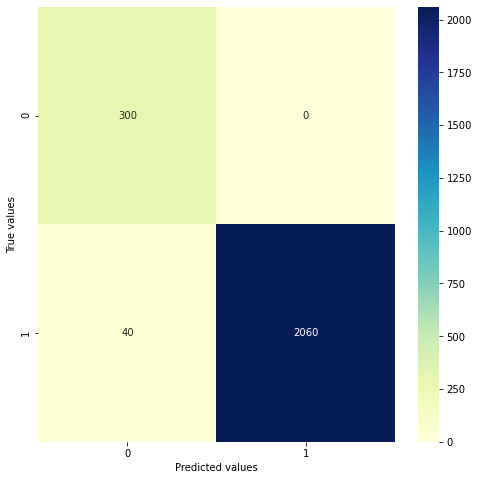

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (8,8))
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d",cmap="YlGnBu")
plt.xlabel("Predicted values")
plt.ylabel("True values")

In [51]:
print(classification_report(y_true = binary_true, y_pred = binary_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       300
           1       1.00      0.98      0.99      2100

    accuracy                           0.98      2400
   macro avg       0.94      0.99      0.96      2400
weighted avg       0.99      0.98      0.98      2400



In [52]:
random_cv_lr.best_estimator_

Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=8.9460645691252, max_iter=10000, n_jobs=1,
                                    random_state=0))])

In [53]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import expon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

# suppose the class_weight are 0.1 for 0 (no PII)  and 0.9 for 1 (PII exist)

pipe_lr_weights = make_pipeline(LogisticRegression(random_state=0 , max_iter=10000,n_jobs = 1,
                                                  class_weight={0:.1, 1:.9}) )
param_grid = {
              'logisticregression__C':expon(scale = 2),
              'logisticregression__penalty':['l2']
}

random_cv_lr_weights = RandomizedSearchCV(estimator= pipe_lr_weights, param_distributions = param_grid,
                                  cv =10, error_score = 0,n_iter = 10 , scoring = 'f1',
                                  return_train_score=True,n_jobs = 2 )
                               


random_cv_lr_weights.fit(pii_matrix, fake_pii['Target'])

RandomizedSearchCV(cv=10, error_score=0,
                   estimator=Pipeline(steps=[('logisticregression',
                                              LogisticRegression(class_weight={0: 0.1,
                                                                               1: 0.9},
                                                                 max_iter=10000,
                                                                 n_jobs=1,
                                                                 random_state=0))]),
                   n_jobs=2,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AB7A129FD0>,
                                        'logisticregression__penalty': ['l2']},
                   return_train_score=True, scoring='f1')

Text(51.0, 0.5, 'True values')

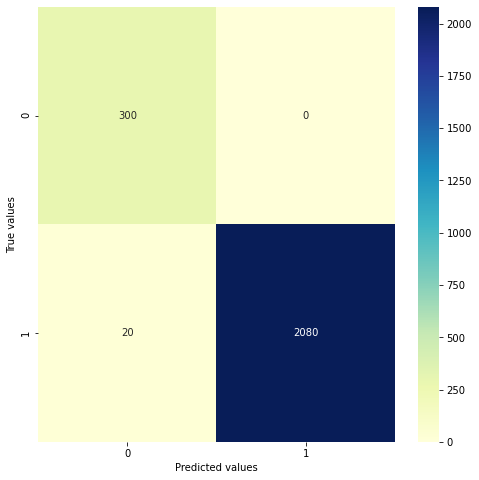

In [54]:
binary_pred = random_cv_lr_weights.predict(pii_matrix_test)
binary_true = fake_pii_test["Target"]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (8,8))
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d",cmap="YlGnBu")
plt.xlabel("Predicted values")
plt.ylabel("True values")

In [55]:
print(classification_report(y_true = binary_true, y_pred = binary_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       300
           1       1.00      0.99      1.00      2100

    accuracy                           0.99      2400
   macro avg       0.97      1.00      0.98      2400
weighted avg       0.99      0.99      0.99      2400



In [56]:
random_cv_lr_weights.best_estimator_

Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=3.338050757035225,
                                    class_weight={0: 0.1, 1: 0.9},
                                    max_iter=10000, n_jobs=1,
                                    random_state=0))])

In [57]:

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(pii_matrix, fake_pii["Target"])
neigh.score(pii_matrix_test, fake_pii_test["Target"])

0.9829166666666667

In [32]:
fake_pii_test["Target"]

0       1
1       0
2       1
3       1
4       1
       ..
2395    1
2396    1
2397    1
2398    1
2399    1
Name: Target, Length: 2400, dtype: int64

In [33]:
fake_pii["Target"]

0       1
1       1
2       1
3       1
4       1
       ..
2395    1
2396    1
2397    1
2398    1
2399    1
Name: Target, Length: 2400, dtype: int64